In [3]:
#all imports

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

from torch.nn import BCELoss
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pickle

In [4]:
#GPU and CPU related

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
data_dir = '/kaggle/input/plantdisease/PlantVillage'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [6]:
pepper_classes = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy'
]

potato_classes = [
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]
all_classes = pepper_classes + potato_classes + tomato_classes

class_counts = {cls: 0 for cls in all_classes}

for path, label in dataset.samples:
    class_name = dataset.classes[label]
    if class_name in all_classes:
        class_counts[class_name] += 1

print("\nFull Dataset Summary:")
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")


Full Dataset Summary:
Class 'Pepper__bell___Bacterial_spot': 997 images
Class 'Pepper__bell___healthy': 1478 images
Class 'Potato___Early_blight': 1000 images
Class 'Potato___Late_blight': 1000 images
Class 'Potato___healthy': 152 images
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images


In [5]:
print("Pepper Classes and Counts:")
for class_name in pepper_classes:
    print(f"Class '{class_name}': {class_counts[class_name]} images")

print("\nPotato Classes and Counts:")
for class_name in potato_classes:
    print(f"Class '{class_name}': {class_counts[class_name]} images")

print("\nTomato Classes and Counts:")
for class_name in tomato_classes:
    print(f"Class '{class_name}': {class_counts[class_name]} images")

Pepper Classes and Counts:
Class 'Pepper__bell___Bacterial_spot': 997 images
Class 'Pepper__bell___healthy': 1478 images

Potato Classes and Counts:
Class 'Potato___Early_blight': 1000 images
Class 'Potato___Late_blight': 1000 images
Class 'Potato___healthy': 152 images

Tomato Classes and Counts:
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images


In [7]:
tomato_class_indices = [i for i, class_name in enumerate(dataset.classes) if any(target in class_name for target in tomato_classes)]
filtered_tomato_indices = [i for i, label in enumerate(dataset.targets) if label in tomato_class_indices]
filtered_tomato_dataset = torch.utils.data.Subset(dataset, filtered_tomato_indices)
print("\nFiltered Tomato Dataset Size:", len(filtered_tomato_dataset))


Filtered Tomato Dataset Size: 16011


In [8]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for our project
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define hyper parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Save the trained model
model_save_path = "trained_model_all_leafs.pth"
torch.save(model.state_dict(), model_save_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Epoch 1/10, Loss: 0.5177
Epoch 2/10, Loss: 0.2201
Epoch 3/10, Loss: 0.1504
Epoch 4/10, Loss: 0.1231
Epoch 5/10, Loss: 0.0829
Epoch 6/10, Loss: 0.0712
Epoch 7/10, Loss: 0.0789
Epoch 8/10, Loss: 0.0651
Epoch 9/10, Loss: 0.0578
Epoch 10/10, Loss: 0.0486


In [10]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model.load_state_dict(torch.load("trained_model_all_leafs.pth"))
model.to(device)

model.eval()

val_loss = 0.0
correct_val = 0
total_val = 0
y_true_val = []
y_pred_val = []

# Evaluate on validation data for tuning
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        

        loss = F.cross_entropy(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

        y_true_val.extend(labels.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_val / total_val

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

print("\nClassification Report on Validation Set:")
print(classification_report(y_true_val, y_pred_val, target_names=dataset.classes))

/tmp/ipykernel_23/780247215.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_model_all_leafs.pth"))


Validation Loss: 0.0523
Validation Accuracy: 98.25%

Classification Report on Validation Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      1.00      0.99        91
                     Pepper__bell___healthy       1.00      1.00      1.00       145
                      Potato___Early_blight       0.96      1.00      0.98        96
                       Potato___Late_blight       0.97      0.98      0.98       107
                           Potato___healthy       0.88      1.00      0.94        22
                      Tomato_Bacterial_spot       1.00      0.97      0.98       219
                        Tomato_Early_blight       0.96      0.93      0.94       110
                         Tomato_Late_blight       0.97      0.97      0.97       174
                           Tomato_Leaf_Mold       1.00      0.99      0.99        95
                  Tomato_Septoria_leaf_spot       0.99 

In [11]:
# Evaluate on the test set
y_true_test = []
y_pred_test = []
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(y_true_test, y_pred_test, target_names=dataset.classes))

conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

Test Loss: 0.0522
Test Accuracy: 98.01%

Classification Report on Test Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      1.00      0.99        99
                     Pepper__bell___healthy       0.99      1.00      1.00       160
                      Potato___Early_blight       0.97      0.99      0.98       114
                       Potato___Late_blight       0.97      0.99      0.98       102
                           Potato___healthy       0.79      1.00      0.88        11
                      Tomato_Bacterial_spot       1.00      0.97      0.99       219
                        Tomato_Early_blight       0.95      0.92      0.93        76
                         Tomato_Late_blight       0.96      0.96      0.96       182
                           Tomato_Leaf_Mold       1.00      0.99      0.99        99
                  Tomato_Septoria_leaf_spot       0.99      0.94      0.9

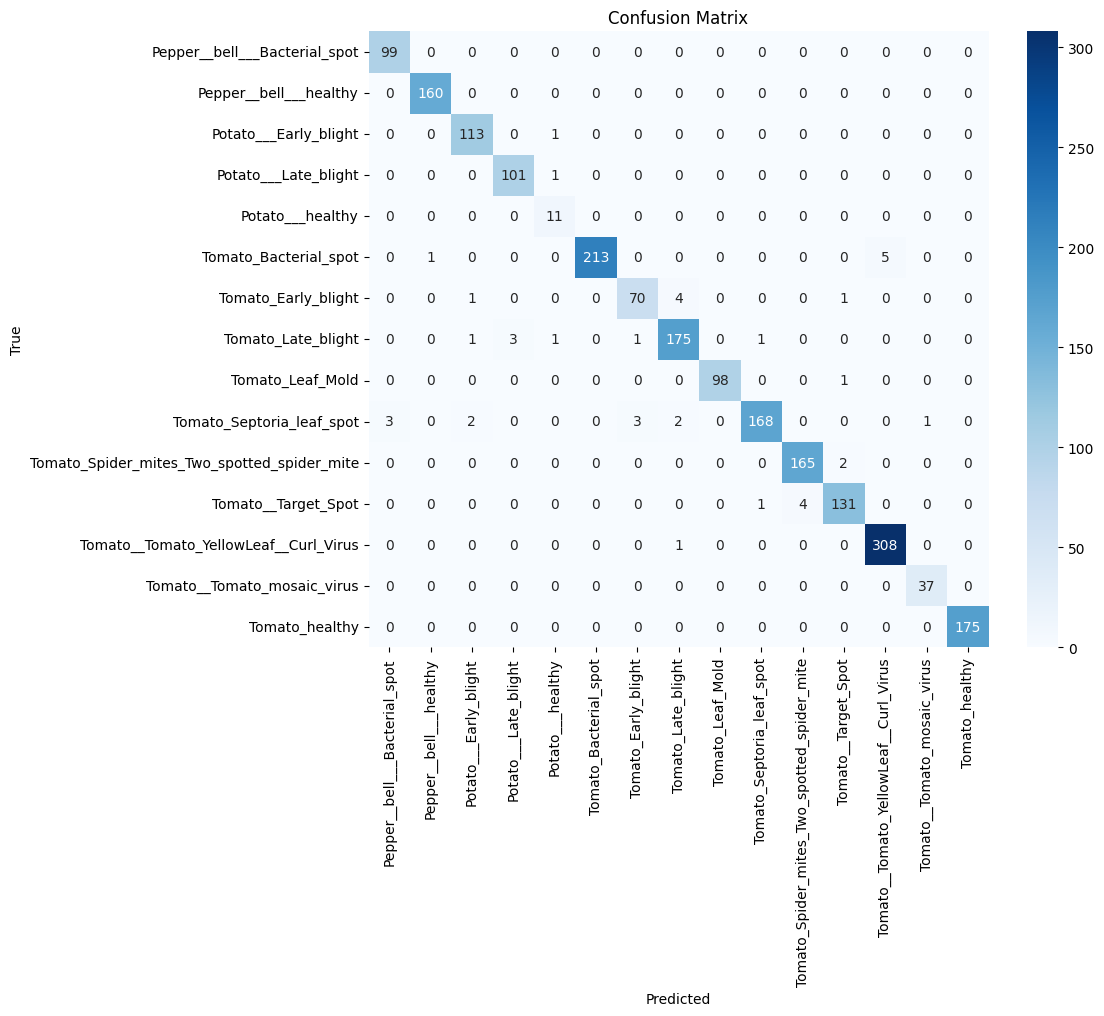

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [15]:
# model architecture
!pip install torchviz

from torchviz import make_dot
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = model(sample_input)
make_dot(output, params=dict(model.named_parameters())).render("resnet50_model_architecture", format="png")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


'resnet50_model_architecture.png'

MobileNetV2 without augmentation

In [9]:
model = models.mobilenet_v2(pretrained=True)

num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Iterate over the training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

model_save_path = "trained_mobilenetv2_model.pth"
torch.save(model.state_dict(), model_save_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.3356
Epoch 2/10, Loss: 0.1589
Epoch 3/10, Loss: 0.1352
Epoch 4/10, Loss: 0.0924
Epoch 5/10, Loss: 0.0946
Epoch 6/10, Loss: 0.0762
Epoch 7/10, Loss: 0.0894
Epoch 8/10, Loss: 0.0632
Epoch 9/10, Loss: 0.0712
Epoch 10/10, Loss: 0.0565


In [10]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model.load_state_dict(torch.load("trained_mobilenetv2_model.pth"))
model.to(device)

model.eval()

val_loss = 0.0
correct_val = 0
total_val = 0
y_true_val = []
y_pred_val = []

# Evaluate the model on validation data
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = F.cross_entropy(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

        y_true_val.extend(labels.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100 * correct_val / total_val

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

print("\nClassification Report on Validation Set:")
print(classification_report(y_true_val, y_pred_val, target_names=dataset.classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)
print("\nConfusion Matrix:")
print(conf_matrix)

/tmp/ipykernel_23/1895809972.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_mobilenetv2_model.pth"))


Validation Loss: 0.1219
Validation Accuracy: 95.83%

Classification Report on Validation Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.95      0.97       104
                     Pepper__bell___healthy       0.96      1.00      0.98       132
                      Potato___Early_blight       1.00      0.99      0.99        84
                       Potato___Late_blight       0.99      0.90      0.94        98
                           Potato___healthy       0.64      0.93      0.76        15
                      Tomato_Bacterial_spot       1.00      0.99      0.99       204
                        Tomato_Early_blight       0.86      0.98      0.92        97
                         Tomato_Late_blight       0.98      0.93      0.96       186
                           Tomato_Leaf_Mold       1.00      0.83      0.91       112
                  Tomato_Septoria_leaf_spot       0.92 

In [11]:
# Evaluate on the test set
y_true_test = []
y_pred_test = []
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(y_true_test, y_pred_test, target_names=dataset.classes))

conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix for Test Set:")
print(conf_matrix_test)

Test Loss: 0.1023
Test Accuracy: 96.95%

Classification Report on Test Set:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.98      0.99       101
                     Pepper__bell___healthy       0.98      1.00      0.99       155
                      Potato___Early_blight       0.99      0.97      0.98       107
                       Potato___Late_blight       0.97      0.94      0.95        95
                           Potato___healthy       0.81      1.00      0.90        13
                      Tomato_Bacterial_spot       1.00      0.99      1.00       196
                        Tomato_Early_blight       0.89      0.97      0.93        98
                         Tomato_Late_blight       0.98      0.96      0.97       190
                           Tomato_Leaf_Mold       1.00      0.82      0.90        95
                  Tomato_Septoria_leaf_spot       0.95      0.99      0.9

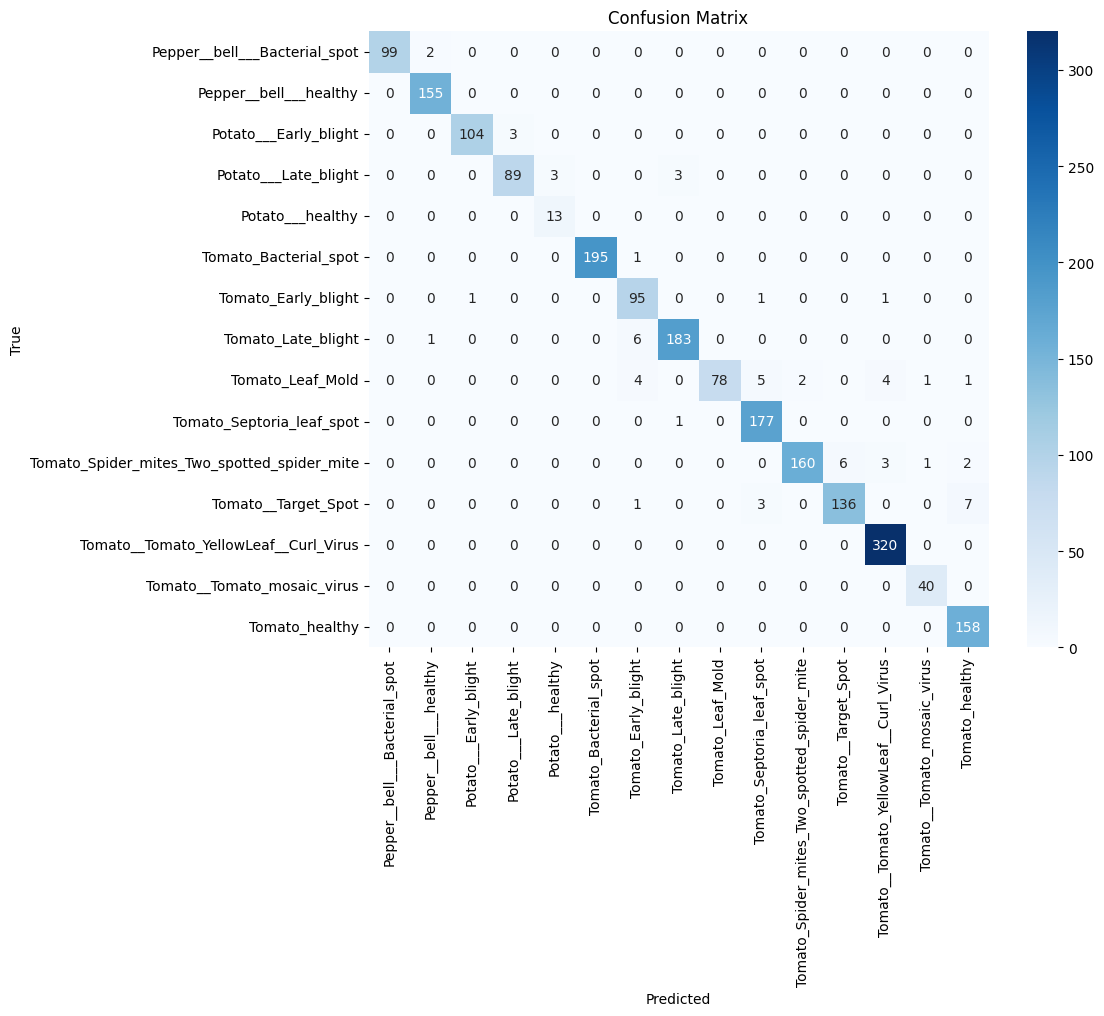

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()